In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, Activation, BatchNormalization, Dropout, Flatten, Reshape, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l1_l2


# def plot_images(images, figsize=(10, 10), fname=None):
#     """ Plot some images """
#     n_examples = len(images)
#     dim = np.ceil(np.sqrt(n_examples))
#     plt.figure(figsize=figsize)
#     for i in range(n_examples):
#         plt.subplot(dim, dim, i + 1)
#         img = np.squeeze(images[i])
#         plt.imshow(img, cmap=plt.cm.Greys)
#         plt.axis('off')
#     plt.tight_layout()
#     if fname is not None:
#         plt.savefig(fname)


def make_trainable(model, trainable):
    """ Helper to freeze / unfreeze a model """
    model.trainable = trainable
    for l in model.layers:
        l.trainable = trainable


def generator_model(inp, n_channels=64):
    """ Generator network """
    z = Dense(7 * 7 * n_channels, activity_regularizer=l1_l2(1e-5))(inp)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Reshape([7, 7, n_channels])(z)
    z = Conv2DTranspose(n_channels // 2, (3, 3), strides=(2, 2), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Conv2DTranspose(n_channels // 2, (3, 3), strides=(2, 2), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Conv2D(n_channels // 2, (3, 3), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    return Conv2D(1, (1, 1), padding='same', activation='sigmoid')(z)




def discriminator_model(inp, drop_rate=0.25):
    """ Discriminator network, we need lots of regularization here to prevent
        vanishing gradients + mode collapsing """
    z = Conv2D(256, (5, 5), padding='same', strides=(2, 2))(inp)
    z = LeakyReLU(0.2)(z)
    z = Dropout(drop_rate)(z)
    z = Conv2D(512, (5, 5), padding='same', strides=(2, 2))(z)
    z = LeakyReLU(0.2)(z)
    z = Dropout(drop_rate)(z)
    z = Flatten()(z)
    z = Dense(256, activity_regularizer=l1_l2(1e-5))(z)
    z = LeakyReLU(0.2)(z)
    z = Dropout(drop_rate)(z)
    return Dense(2, activation='softmax')(z)

## part 1

In [0]:
import os,random
import numpy as np

from tqdm import tqdm
from keras.datasets import mnist
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
# import dlipr
# from gan import generator_model, discriminator_model, plot_images, make_trainable


# prepare MNIST dataset
(train_images, y_train), (test_images, y_test) = mnist.load_data()
X_train = train_images.reshape(-1, 28, 28, 1) / 255.
X_test = test_images.reshape(-1, 28, 28, 1) / 255.

# # plot some real images
# idx = np.random.choice(len(X_train), 16)
# plot_images(X_train[idx], fname='real_images.png')


# --------------------------------------------------
# Set up generator, discriminator and GAN (stacked generator + discriminator)
# Feel free to modify the provided models.
# --------------------------------------------------
# Set up generator

# we don't call the generator by itself, hence no compilation needed
print('\nGenerator')
latent_dim = 100  # Dimension of the latent (noise) space
g_input = Input(shape=[latent_dim])
g_output = generator_model(g_input)
generator = Model(g_input, g_output)
print(generator.summary())

# Set up discriminator
print('\nDiscriminator')
d_input = Input(shape=(28, 28, 1))
d_output = discriminator_model(d_input)
discriminator = Model(d_input, d_output)
print(discriminator.summary())
d_opt = Adam(lr=1e-3)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=['accuracy'])

# --------------------------------------------------
# Pretrain the discriminator:
# - Create a dataset of 10000 real train images and 10000 fake images.
# - Train the discriminator for 1 epoch on this dataset.
# - Create a dataset of 5000 real test images and 5000 fake images.
# - Evaluate the test accuracy of your network.
# --------------------------------------------------


ntrain = 10000
ntest = 5000

trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XTr = X_train[trainidx,:,:,:]

testidx = random.sample(range(0,X_test.shape[0]), ntest)
XTe = X_train[testidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen_train = np.random.uniform(0,1,size=[XTr.shape[0],100])
noise_gen_test = np.random.uniform(0,1,size=[XTe.shape[0],100])
generated_images_train = generator.predict(noise_gen_train)
generated_images_test = generator.predict(noise_gen_test)

Xtr = np.concatenate((XTr, generated_images_train))
n = XTr.shape[0]
ytr = np.zeros([2*n,2])
ytr[:n,1] = 1
ytr[n:,0] = 1

Xte = np.concatenate((XTe, generated_images_test))
n = XTe.shape[0]
yte = np.zeros([2*n,2])
yte[:n,1] = 1
yte[n:,0] = 1

make_trainable(discriminator,True)
print(Xtr.shape)
print(ytr.shape)
print(Xte.shape)
print(yte.shape)

discriminator.fit(Xtr, ytr, batch_size=100,epochs=1,verbose=1,validation_data=(Xte, yte))
# y_hat = discriminator.predict(X)



Generator
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        18464     
___________________________________________________________

## part 2

In [0]:
from IPython import display
def plot_loss(losses):
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()
        
def plot_gen(n_ex=8,dim=(1,8), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)
#     print(generated_images.shape)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]  
#         print(img.shape)
        plt.imshow(img,interpolation='bilinear', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show() 
    
losses = {"d":[], "g":[]}         


In [0]:
# Set up GAN by stacking the discriminator on top of the generator
print('\nGenerative Adversarial Network')
gan_input = Input(shape=[latent_dim])
gan_output = discriminator(generator(gan_input))
GAN = Model(gan_input, gan_output)
print(GAN.summary())
g_opt = Adam(lr=1e-4)
GAN.compile(loss='binary_crossentropy', optimizer=g_opt)

def train_for_n(nb_epoch, plt_frq,BATCH_SIZE):
    for e in (range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss[0])
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1

        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()

# --------------------------------------------------
# Implement main training loop:
# - Repeat for number of epochs
#   - Repeat for one epoch
#      - Create a mini-batch of data (X: real images + fake images, y: corresponding class vectors)
#      - Train the discriminator on the mini-batch
#      - Freeze the discriminator: make_trainable(discriminator, False)
#      - Create a mini-batch of data (X: noise, y: class vectors pretending that these produce real images)
#      - Train the generator on the mini-batch
#      - Unfreeze the discriminator: make_trainable(discriminator, True)
#   - Plot some fake images
# - Plot the loss of discriminator and generator as function of training steps
#
# Note: Training GANs requires careful tuning of the learning rates.
# You can try following
# - Train for 3 epochs with original learning rates
# - Train for 3 epochs at reduced learning rates
#     g_opt.lr = 1e-5
#     d_opt.lr = 1e-4
# - Train for 2 epochs at reduced learning rates
#     g_opt.lr = 1e-6
#     d_opt.lr = 1e-5
# --------------------------------------------------



Generative Adversarial Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         366657    
_________________________________________________________________
model_2 (Model)              (None, 2)                 9707266   
Total params: 10,073,923
Trainable params: 10,067,459
Non-trainable params: 6,464
_________________________________________________________________
None


## part 3

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


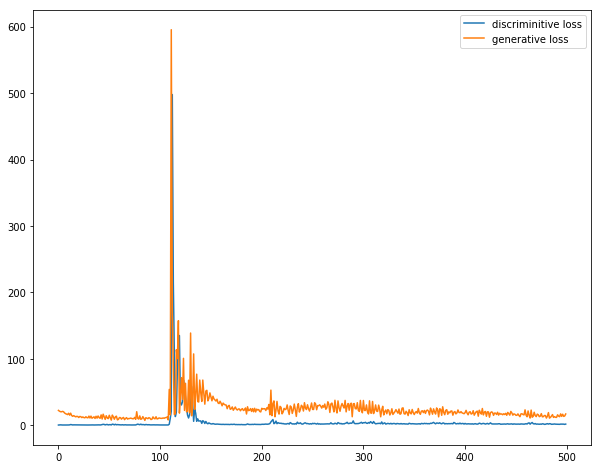

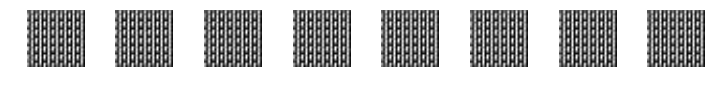

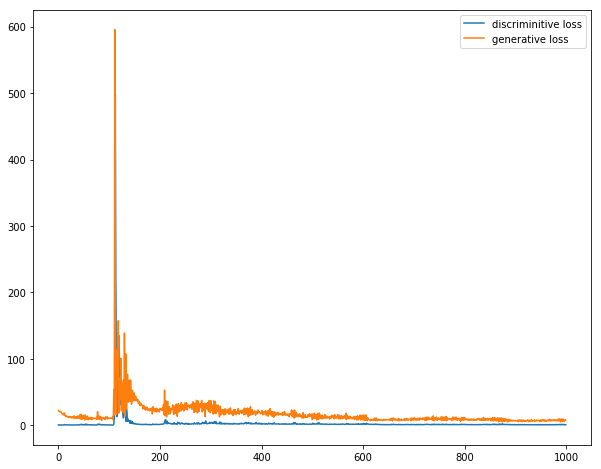

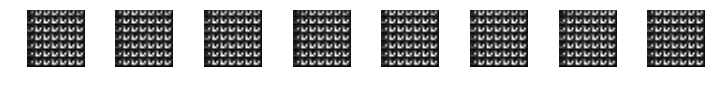

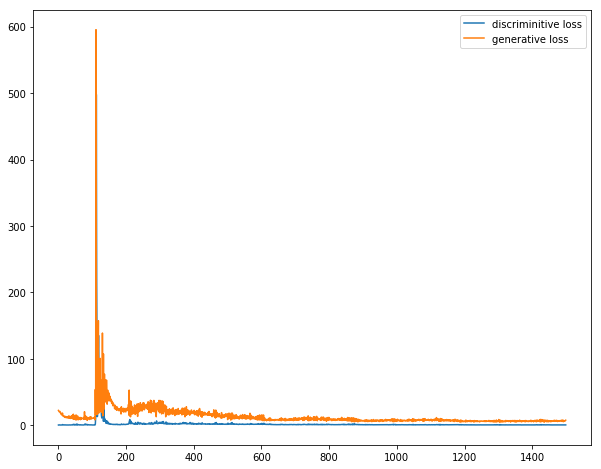

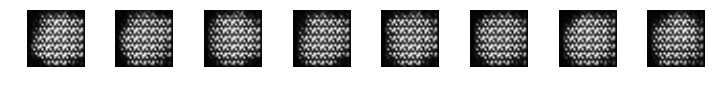

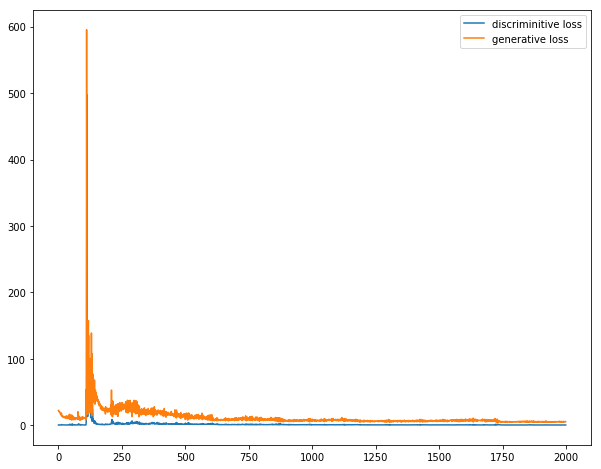

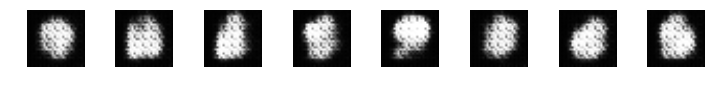

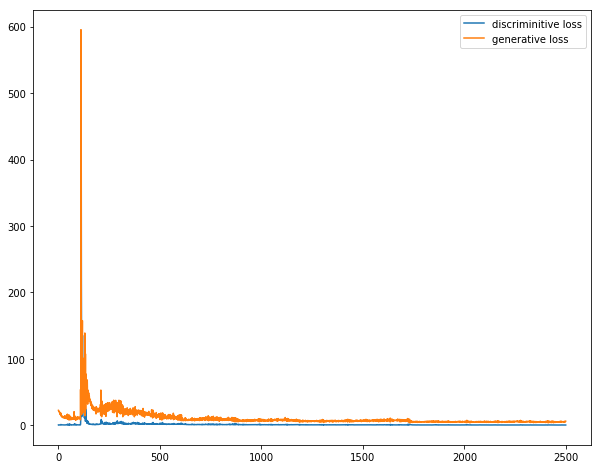

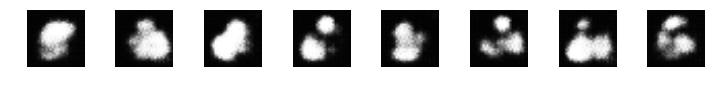

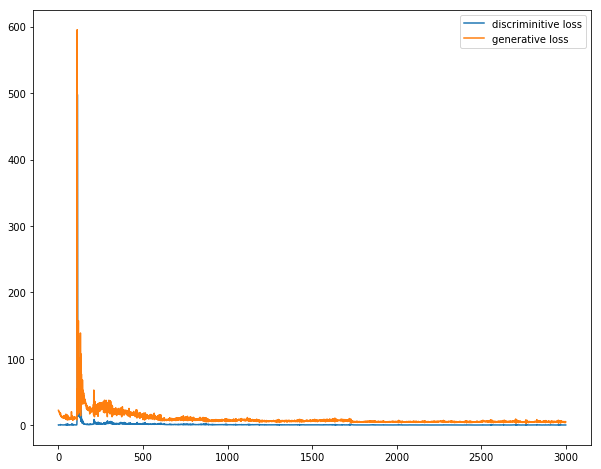

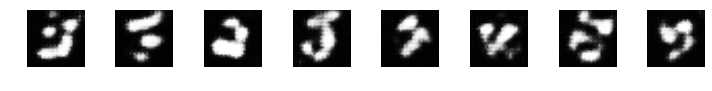

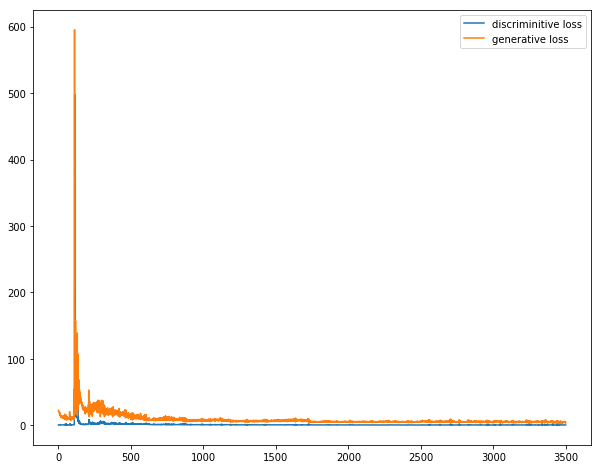

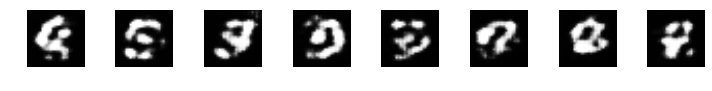

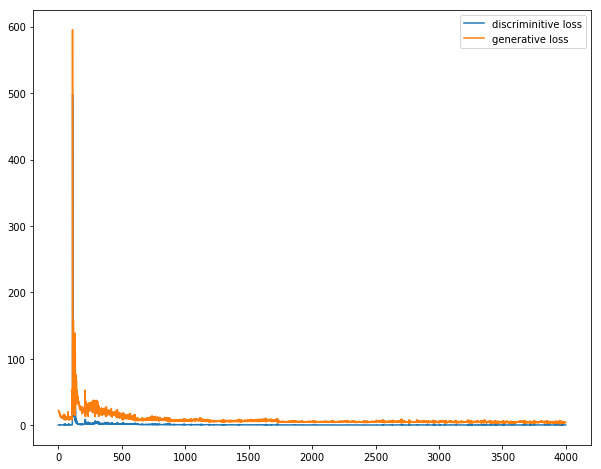

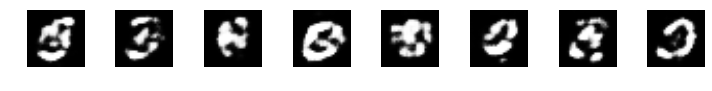

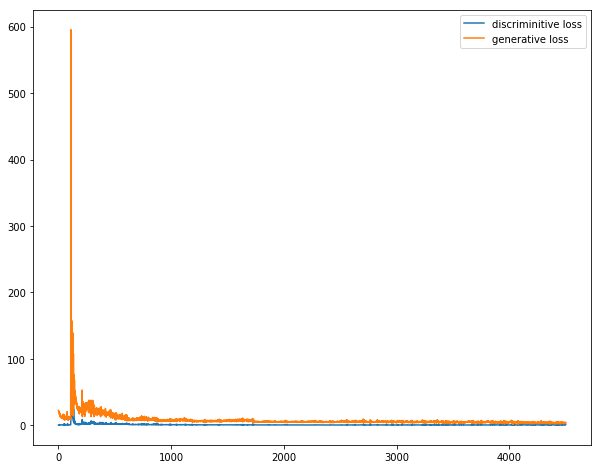

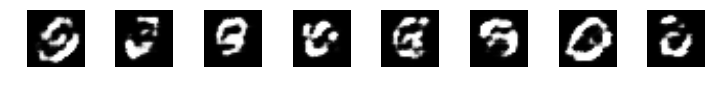

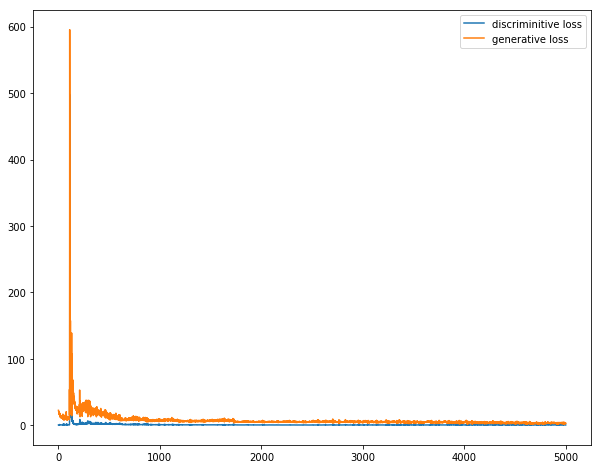

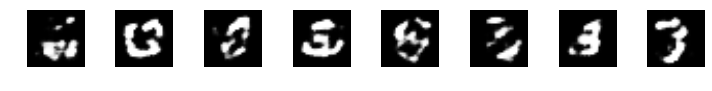

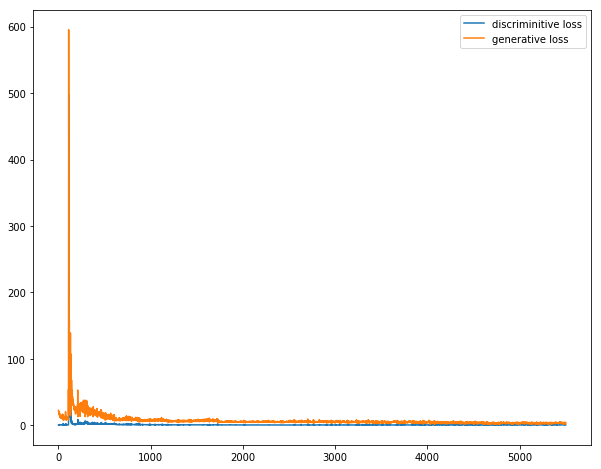

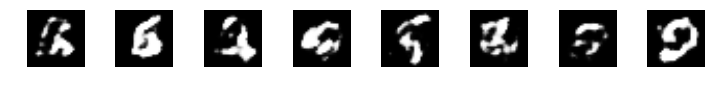

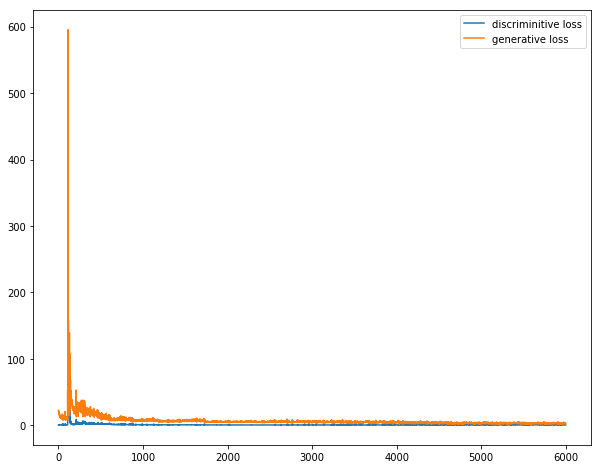

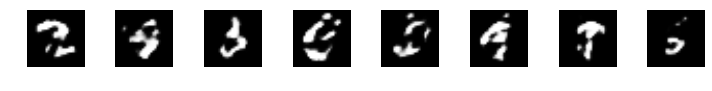

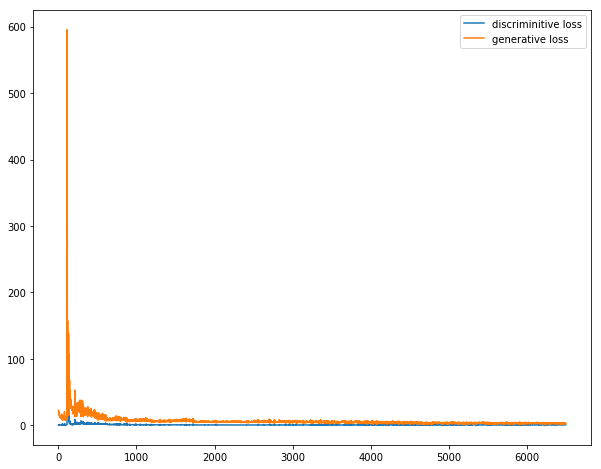

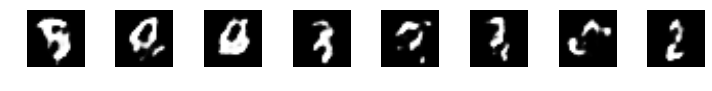

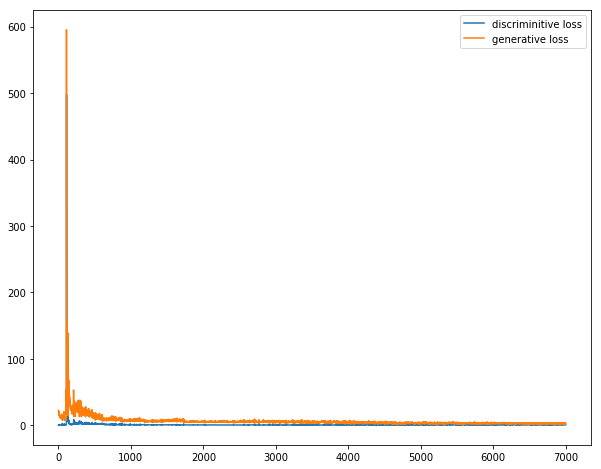

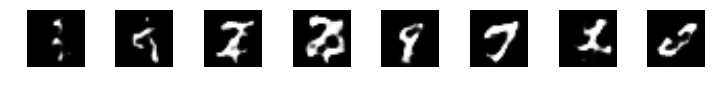

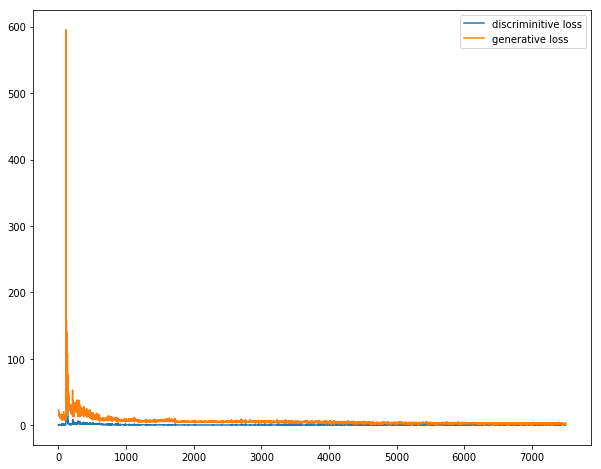

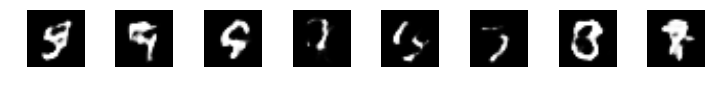

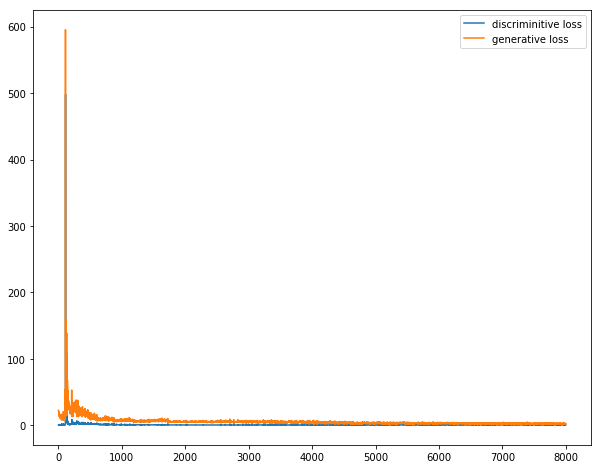

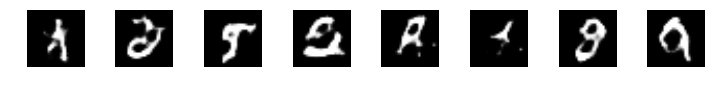

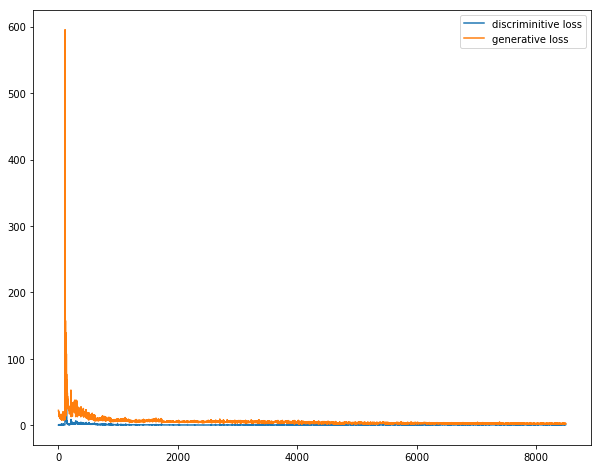

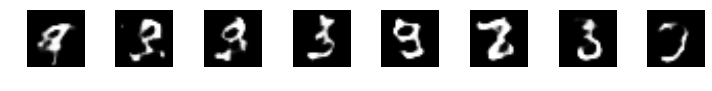

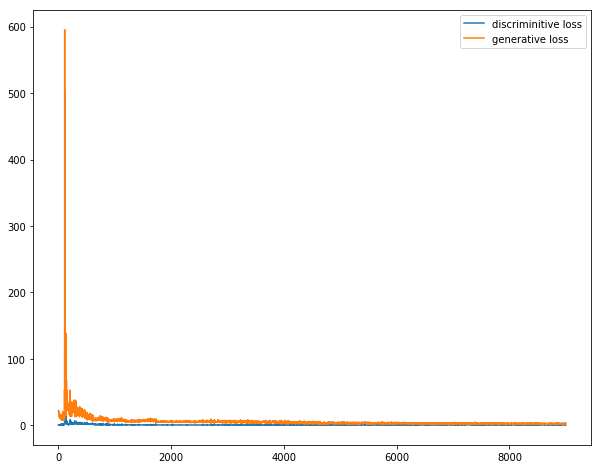

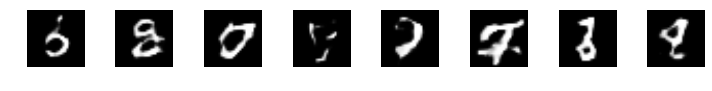

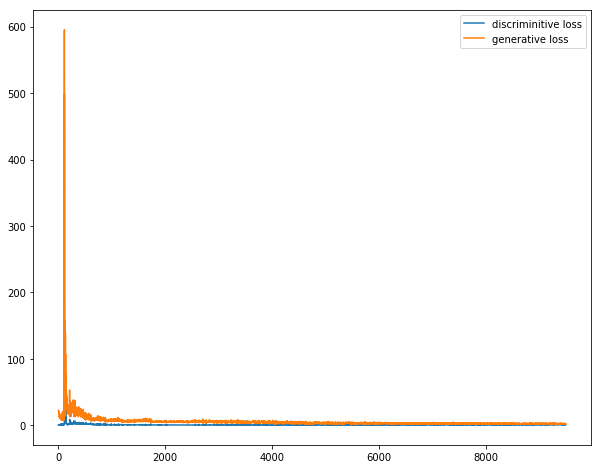

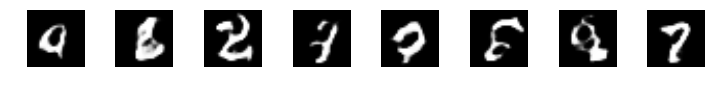

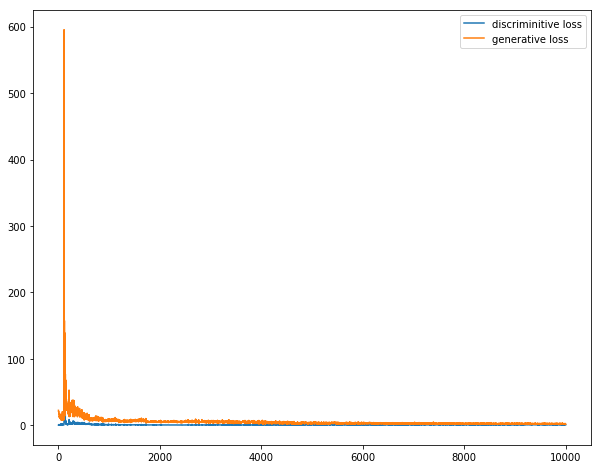

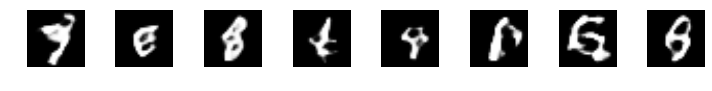

In [0]:
train_for_n(nb_epoch=10000, plt_frq=500,BATCH_SIZE=32)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


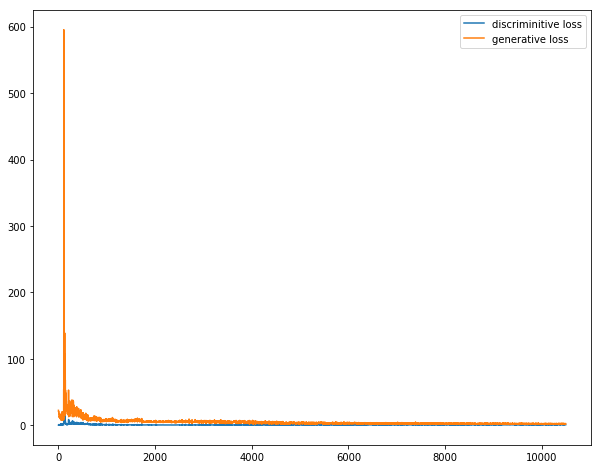

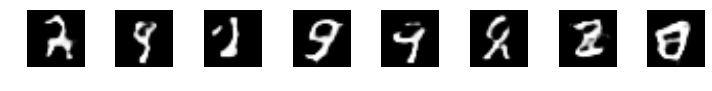

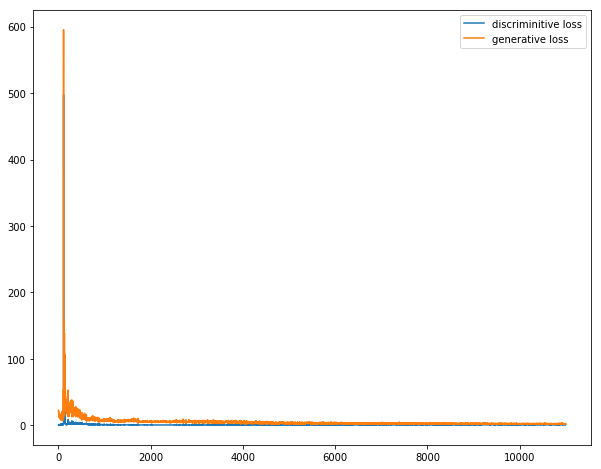

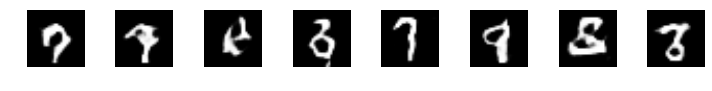

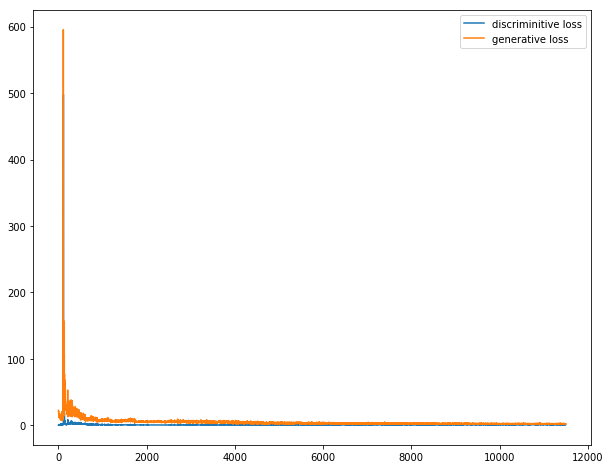

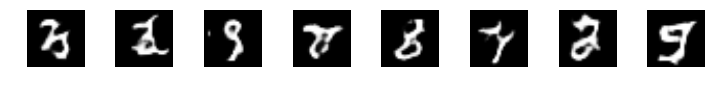

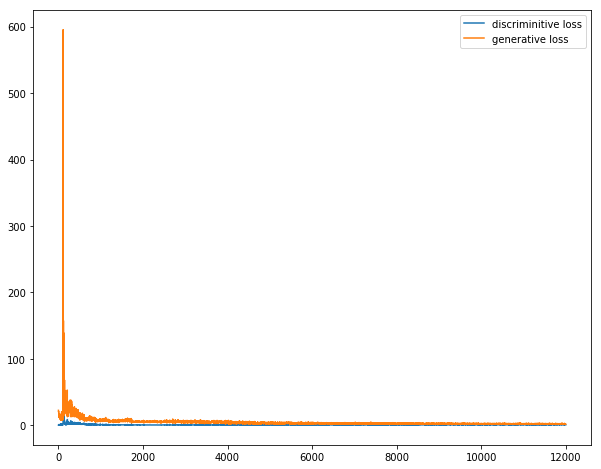

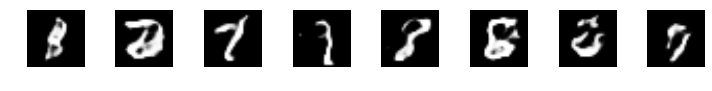

In [0]:
g_opt.lr = 1e-5
d_opt.lr = 1e-4
train_for_n(nb_epoch=2000, plt_frq=500,BATCH_SIZE=32)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


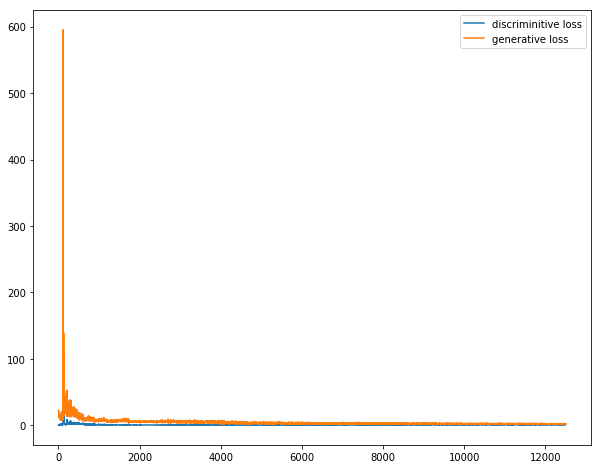

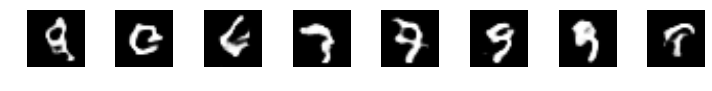

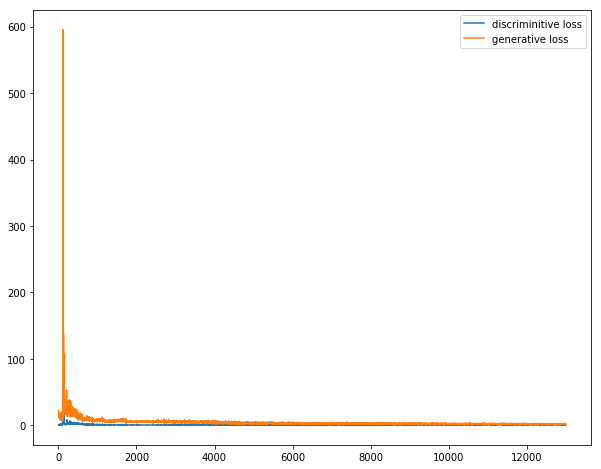

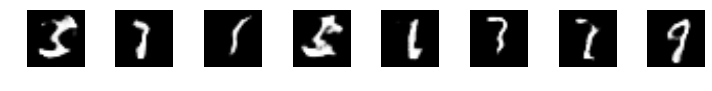

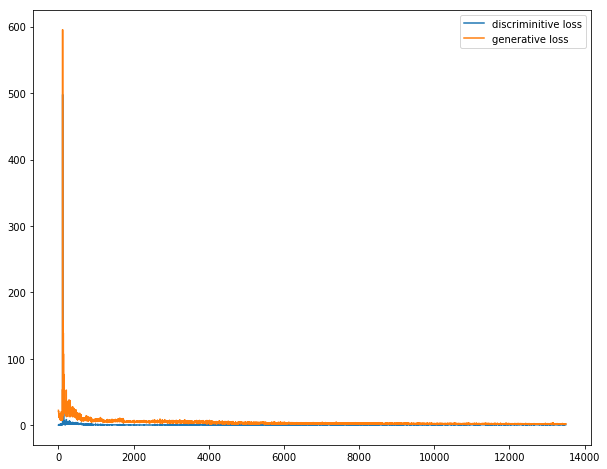

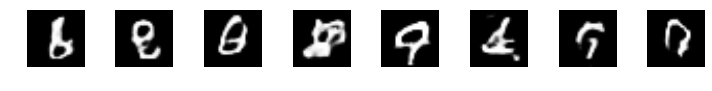

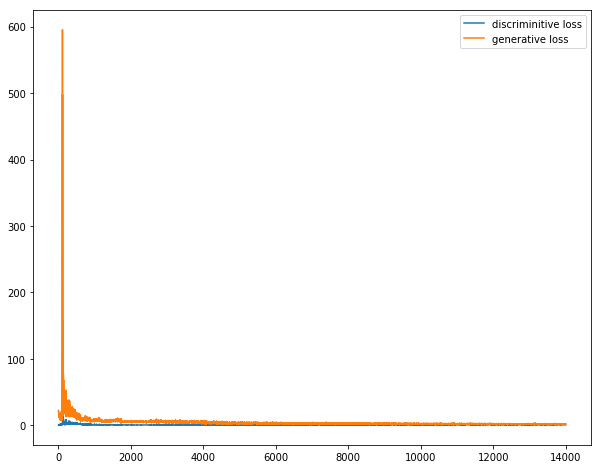

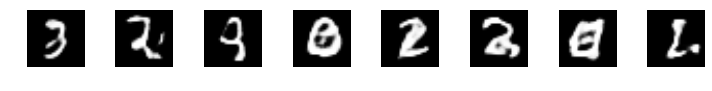

In [0]:
g_opt.lr = 1e-6
d_opt.lr = 1e-5
train_for_n(nb_epoch=2000, plt_frq=500,BATCH_SIZE=32)